In [ ]:

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [ ]:

DATA_PATH = '/content/kidney_disease.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please upload 'kidney_disease.csv' to /content/")

df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
df.head()



Dataset loaded. Shape: (400, 26)


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [ ]:

print(df.columns.tolist())
print(df.shape)
print(df['classification'].value_counts(dropna=False).head())

# Clean 'classification' column (some datasets have trailing tabs/spaces)
df['classification'] = df['classification'].astype(str).str.strip().str.replace('\t', '', regex=True).str.lower()

# Map to binary target (1 = ckd, 0 = notckd)
df['target'] = df['classification'].map(lambda x: 1 if 'ckd' in x and 'not' not in x else 0)

# Drop obvious id column if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print("After target mapping - value counts:")
print(df['target'].value_counts())



['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
(400, 26)
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64
After target mapping - value counts:
target
1    250
0    150
Name: count, dtype: int64


In [ ]:

possible_numeric = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
for col in possible_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Separate columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from num_cols
num_cols = [c for c in num_cols if c != 'target']
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'classification']  # classification already mapped

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)



Numeric cols: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
Categorical cols: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [ ]:

for col in num_cols:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

for col in cat_cols:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode().iloc[0]
        df[col] = df[col].fillna(mode_val)

print("Missing values per column after fill:")
print(df.isna().sum())



Missing values per column after fill:
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
target            0
dtype: int64


In [ ]:

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Optional: persist encoders later if you save model
print("Label encoders created for:", list(label_encoders.keys()))



Label encoders created for: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [ ]:
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = np.clip(df[col], lower, upper)



In [ ]:

X = df.drop(columns=[c for c in ['classification','target'] if c in df.columns])
y = df['target']
print("Feature shape:", X.shape, "Target shape:", y.shape)



Feature shape: (400, 24) Target shape: (400,)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/Test sizes:", X_train.shape, X_test.shape)



Train/Test sizes: (320, 24) (80, 24)


In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

model_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = {
        "model": model,
        "accuracy": acc,
        "y_pred": y_pred
    }
    print(f"{name} - Accuracy: {acc:.4f}")



Logistic Regression - Accuracy: 0.9750
Decision Tree - Accuracy: 0.9750
Random Forest - Accuracy: 1.0000


In [ ]:

results_df = pd.DataFrame([
    {"Model": name, "Accuracy": info['accuracy']}
    for name, info in model_results.items()
]).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\nModel comparison:")
display(results_df)

best_model_name = results_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest model: {best_model_name} (Accuracy = {results_df.iloc[0]['Accuracy']:.4f})")




Model comparison:


,Model,Accuracy
0,Random Forest,1.000
1,Logistic Regression,0.975
2,Decision Tree,0.975



Best model: Random Forest (Accuracy = 1.0000)


Classification Report (Best model):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        30
           1     1.0000    1.0000    1.0000        50

    accuracy                         1.0000        80
   macro avg     1.0000    1.0000    1.0000        80
weighted avg     1.0000    1.0000    1.0000        80

Confusion Matrix:
 [[30  0]
 [ 0 50]]


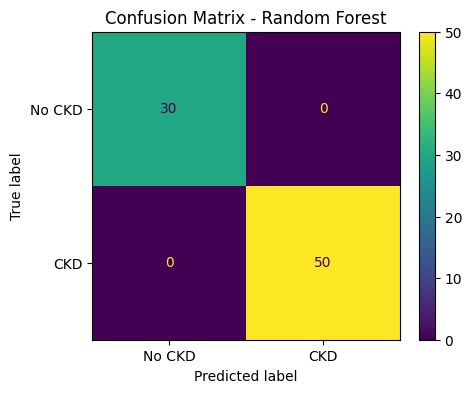

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test_scaled)
print("Classification Report (Best model):\n")
print(classification_report(y_test, y_pred_best, digits=4))

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No CKD", "CKD"])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()



In [ ]:

print("5-fold cross-validation (accuracy) for each model:")
for name, info in model_results.items():
    model = info['model']
    scores = cross_val_score(model, scaler.transform(X), y, cv=5, scoring='accuracy')
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")



5-fold cross-validation (accuracy) for each model:
Logistic Regression: mean=0.9900, std=0.0094
Decision Tree: mean=0.9750, std=0.0137
Random Forest: mean=0.9900, std=0.0094


In [ ]:

OUTPUT_DIR = '/content/nephropredict_artifacts'
os.makedirs(OUTPUT_DIR, exist_ok=True)

joblib.dump(best_model, os.path.join(OUTPUT_DIR, 'nephropredict_best_model.pkl'))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, 'nephropredict_scaler.pkl'))
joblib.dump(label_encoders, os.path.join(OUTPUT_DIR, 'nephropredict_label_encoders.pkl'))
joblib.dump(X.columns.tolist(), os.path.join(OUTPUT_DIR, 'nephropredict_feature_list.pkl'))

print("Saved best model and preprocessing artifacts to:", OUTPUT_DIR)



Saved best model and preprocessing artifacts to: /content/nephropredict_artifacts


In [ ]:
sample = {}

for col in X.columns:
    # provide a default: numeric -> mean, categorical -> mode encoded
    if col in num_cols:
        sample[col] = float(df[col].mean())
    else:
        # categorical columns - use the mode (as original string) then label encode
        mode_val = df[col].mode().iloc[0]
        sample[col] = int(mode_val)



sample_df = pd.DataFrame([sample], columns=X.columns)
sample_scaled = scaler.transform(sample_df)
pred = best_model.predict(sample_scaled)[0]
prob = best_model.predict_proba(sample_scaled)[0] if hasattr(best_model, "predict_proba") else None

print("Sample input prediction:", "CKD" if pred==1 else "No CKD")
if prob is not None:
    print("Probability (No CKD, CKD):", prob)



Sample input prediction: CKD
Probability (No CKD, CKD): [0.01 0.99]


In [ ]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00


In [ ]:
joblib.dump(best_model, '/content/nephropredict_artifacts/best_model.pkl')


['/content/nephropredict_artifacts/best_model.pkl']